In [214]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns

from src.lif import lif_compute, spike_binary, id_synaptic_waveform
from src.ou_process import ouprocess_gaussian
from src.spike_sync import find_synced_spikes

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
NUM_NEURONS = 1000 # 100
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 1.0e3 # 50.0e3
tt = np.arange(0.0, t_stop, dt)
# p.dt = dt; p.tStop = t_stop; ????????
tw = 100.0

In [216]:
V = np.zeros((tt.shape[0], NUM_NEURONS)) # Membrane potential per neuron

# Additive noise to individual neurons
ETA, _ = ouprocess_gaussian(5.0, dt, t_stop, NUM_NEURONS)

In [217]:
# Slow Signal
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

F_binary = np.zeros((tt.shape[0], NUM_NEURONS))
avg_firing_rate = np.zeros(NUM_NEURONS)
a2 = 25.0 # pA; std of noise

I_total = a2*ETA + i_inj

for k in range(0, NUM_NEURONS):
    V[:,k] = lif_compute(I_total[:, k], R, tau_V, V_th, dt)

In [218]:
F_binary = spike_binary(V)
avg_firing_rate = np.sum(F_binary, axis=0)/(t_stop/1.0e3)

(array([  6.,  28., 141., 210., 243., 248.,  74.,  40.,   7.,   3.]),
 array([ 4. ,  6.4,  8.8, 11.2, 13.6, 16. , 18.4, 20.8, 23.2, 25.6, 28. ]),
 <a list of 10 Patch objects>)

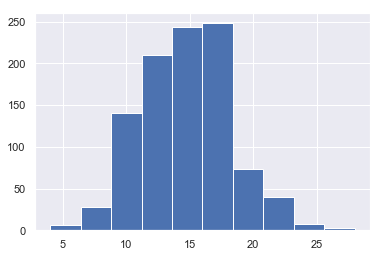

In [219]:
plt.hist(avg_firing_rate)

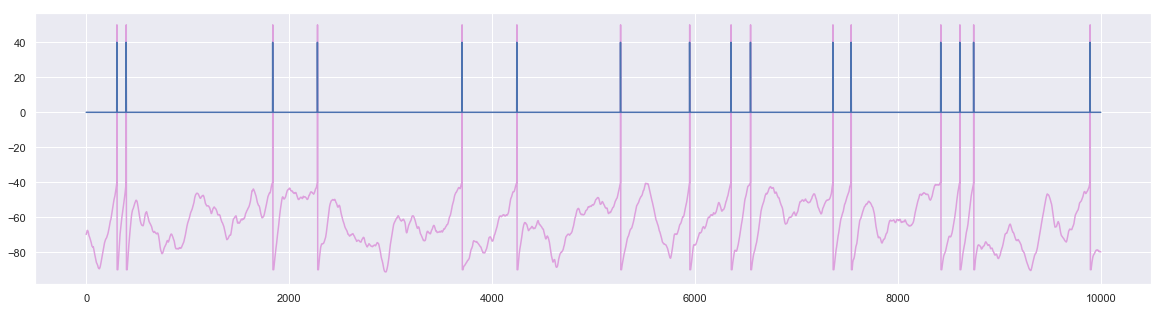

In [220]:
trial = 10
plt.figure(figsize=(20,5))
plt.plot(V[:,trial], color='plum')
plt.plot(F_binary[:,trial] * 40.0)
plt.show()

In [221]:
F_binary.shape

(10000, 1000)

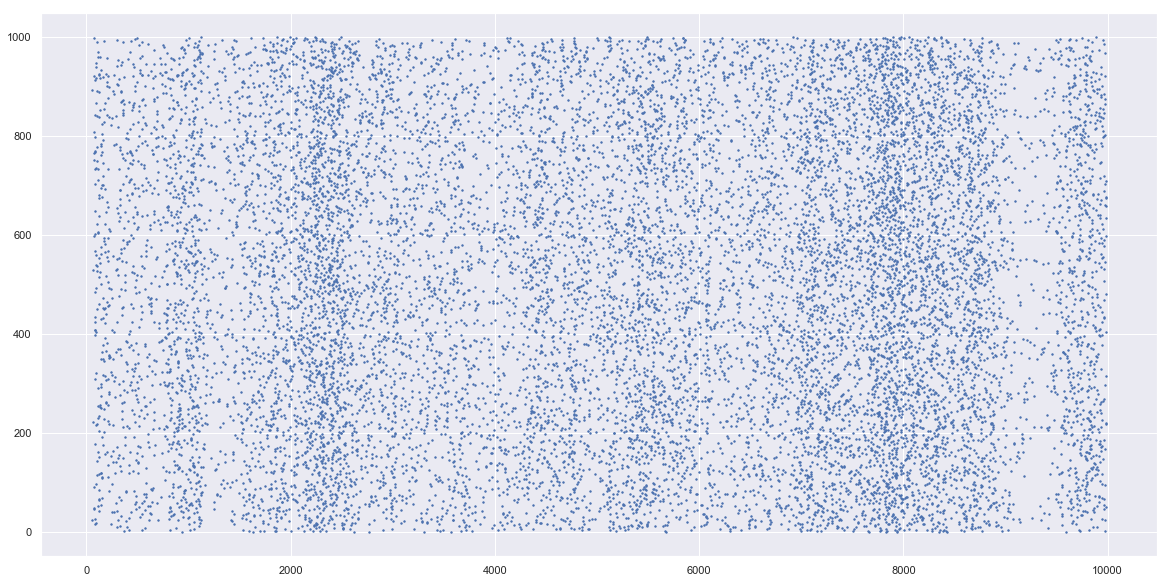

In [222]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)

In [223]:
# ind = 0*1e3/p.dt+1:10*1e3/p.dt;
# q=2;
percentage_sync = 0.5
window_sync = 5
TW = 1
psth_total = np.sum(F_binary,axis=1) # Sum of spikes from all neurons at a given t
# psth_ = psth_total(ind);
indx_async, indx_sync, sync_event, M_S = find_synced_spikes(psth_total, percentage_sync, window_sync, TW, NUM_NEURONS, dt, t_stop)
# sig_sync = M_S;
# sig_async = not M_S;
# Sig_T{1}=sig_async(ind);
# Sig_T{2}=sig_sync(ind);
# sig_sync

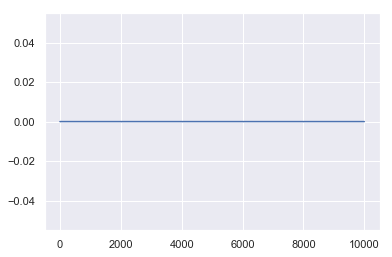

In [224]:
plt.plot(M_S)

In [225]:
v_E = 0.0
v_ave = -67.0

tau_rise = 0.5
tau_fall = 5.0
syn_kernel_len = 50.0

syn_waveform = id_synaptic_waveform(dt, syn_kernel_len, tau_rise, tau_fall)
syn_wave_len = syn_waveform.shape[0]
t_steps = F_binary.shape[0]

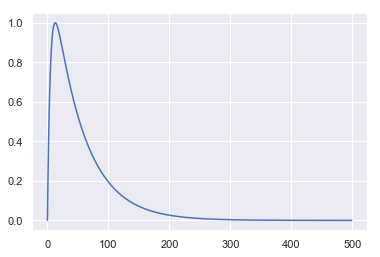

In [226]:
plt.plot(syn_waveform)

In [227]:
F_synaptic = np.zeros(F_binary.shape)
for neuron in range(0, NUM_NEURONS):
    fr_fast = np.convolve(F_binary[:,neuron], syn_waveform)
    F_synaptic[:, neuron] = fr_fast[:-syn_wave_len+1]

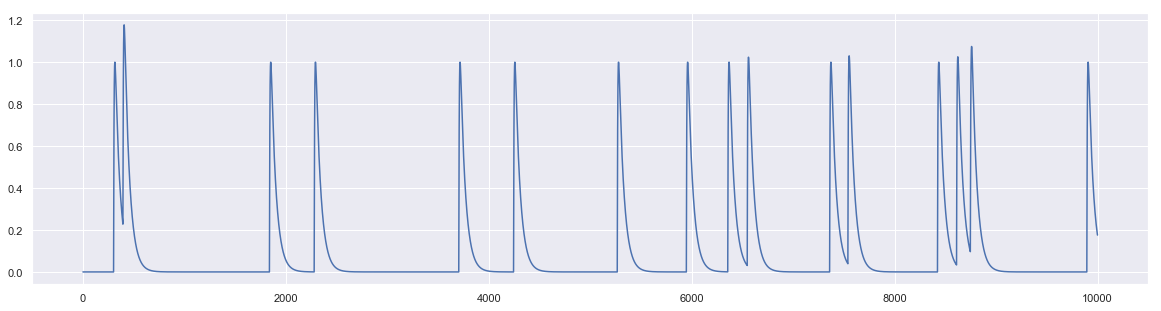

In [228]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])
# plt.plot(F_binary[:,10])

In [241]:
ind_neur = np.arange(0, NUM_NEURONS)
Phi = F_synaptic[:t_steps, ind_neur]
X2 = -v_ave*np.ones((t_steps,ind_neur.shape[0])) + v_E

A = np.multiply(Phi, X2)
W, residuals, rank, s = np.linalg.lstsq(A, i_inj)
reconstructed = np.dot(A, W)

C:\Miniconda\envs\neural-learning\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


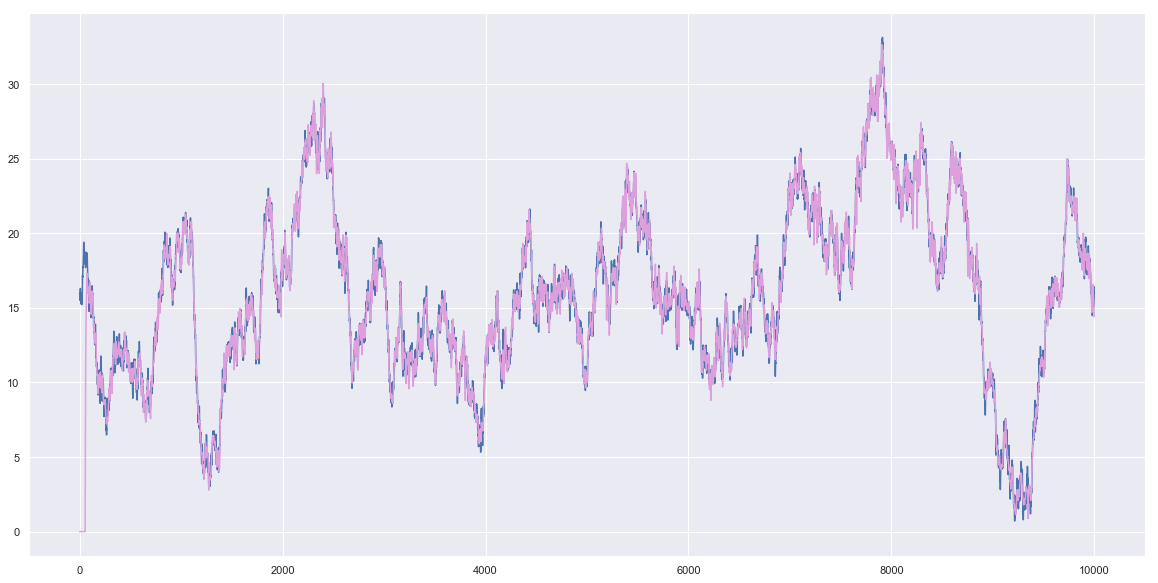

In [244]:
plt.figure(figsize=(20,10))
plt.plot(i_inj)
plt.plot(reconstructed, 'plum')

C:\Miniconda\envs\neural-learning\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(1000, 1)

(10000, 1)

In [12]:
# TESTING OUT VECTORIZED
k = 0
I_total = i_inj + a2*ETA[:,k]
V[:,k] = lif_compute(I_total, R, tau_V, V_th, dt)
V_selected = V[:, k, None]